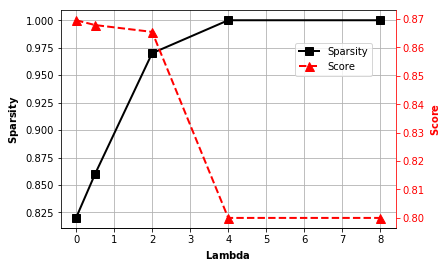

In [199]:
import cv2
import os
import torch 
import numpy as np
import sys
import matplotlib.pyplot as plt

lambda_i = [0, 0.5, 2, 4, 8]

# C3D
# axis_y = [0.967114, 0.967, 0.964492, 0.960856, 0.949976]
# sparsity = [0.64, 0.89, 0.90, 0.96, 0.97]
# lable_2 = 'Accuracy'
# label_data = ["(0, 0, 0, 0, 0, 0, 0, 0)",
#               "(3, 3, 3, 3, 3, 3, 3, 3)",
#               "(7, 2, 3, 2, 3, 3, 4, 4)",
#               "(10, 7, 5, 5, 5, 5, 5, 2)",
#               "(17, 9, 5, 5, 6, 6, 6, 5)"
#             ]
# 3D Unet
axis_y = [0.8695406, 0.8678476, 0.8654427, 0.8, 0.8]
label_2 = 'Score'
sparsity = [0.82, 0.86, 0.97, 1, 1]
label_data = ["(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
              "(0, 0, 0, 1, 1, 1, 1, 1, 1, 1,   1, 1, 1, 1, 1, 1, 1, 1, 1, 1,   1, 1, 1, 1, 1, 1, 1, 1, 0, 0)",
              "(0, 1, 4, 5, 3, 3, 4, 4, 5, 5,   5, 5, 4, 5, 5, 5, 4, 5, 5, 5,   5, 5, 5, 5, 5, 5, 5, 5, 5, 5)",
              "(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
              "(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
            ]

fig, ax = plt.subplots(1,1)
color = (0, 0, 0)
ax.plot(lambda_i, sparsity, 'x-', marker='s', color=color,  linewidth=2, markersize=8, label='Sparsity')
# for i in range(5):
#     ax.text(lambda_i[i], sparsity[i],label_data[i], verticalalignment='top', horizontalalignment='right' )
ax.set_xlabel(r"$\bf{Lambda}$"+' ' + r"$\bf{}$", size=10, family="Arial")
# ax.set_ylabel(r"$\bf{Sparsity}$"+' ' + r"$\bf{(%)}$", size=10, color=color, family="Arial")
ax.set_ylabel(r"$\bf{Sparsity}$"+' ' + r"$\bf{(%)}$", size=10, color=color)
# ax.legend (loc='upper right')
plt.grid(True)
from matplotlib.pyplot import MultipleLocator
inst = plt.gca()
# x_major_locator=MultipleLocator(0.1)
# inst.xaxis.set_major_locator(x_major_locator)
# inst.set_xlim(0.65,1.25)

ax1 = ax.twinx()
color1 = (1, 0, 0)
ax1.plot(lambda_i, axis_y, '--', marker='^', color=color1,  linewidth=2, markersize=9, label=label_2)
ax1.set_ylabel(r"$\bf{"+ label_2+"}$"+' ' + r"$\bf{}$", size=10, color=color1)
# ax1.legend(loc='upper right')
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=(0.7, 0.7))

ax.spines['left'].set_color(color)
ax.tick_params(axis='y', colors=color)
# ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(color1)
ax1.tick_params(axis='y', colors=color1)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.savefig(os.path.join(sys.path[0],'lambda.svg'), format='svg')
plt.show()

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

bar_width = 0.1
def csv2fig(CSV_PATH, FIG_PATH):
    data = pd.read_csv(CSV_PATH)
    # data_loss = data[['train Loss']] #class 'pandas.core.frame.DataFrame'
    # data_acc = data[['training accuracy']]
    proportion = data.iloc[-1,2:] 
    nlayer = 30
    tdvd_range = 2
    plt.figure(figsize=(30,25))
    plt.suptitle('quant_extract_10bit.yaml, batch_150, scale_factor, (nozeros,1,2,-2,-1,respectively)')
    for i in range(nlayer):
        proportion[(2*tdvd_range+1)*i] = 100-proportion[(2*tdvd_range+1)*i] 
        plt.subplot(5,6,i+1)
        x = np.arange(-tdvd_range,tdvd_range+1)
        y = np.array(proportion[(2*tdvd_range+1)*i : (2*tdvd_range+1)*(i+1)])
        #plt.bar(bar_width*1*(i - 4) + np.array(x) ,np.array(y),label="Conv "+str(i+1) , width=bar_width, color=(0,0,0) )
        plt.bar(np.array(x) ,np.array(y), width=bar_width, color=(0,0,0), label = 'Conv' + str(i) )
        plt.legend()   #显示标签
        
    plt.savefig(FIG_PATH, format='svg')
    #plt.show()
csv2fig('tdvd.csv','tdvd.svg')



IndexError: single positional indexer is out-of-bounds

630
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


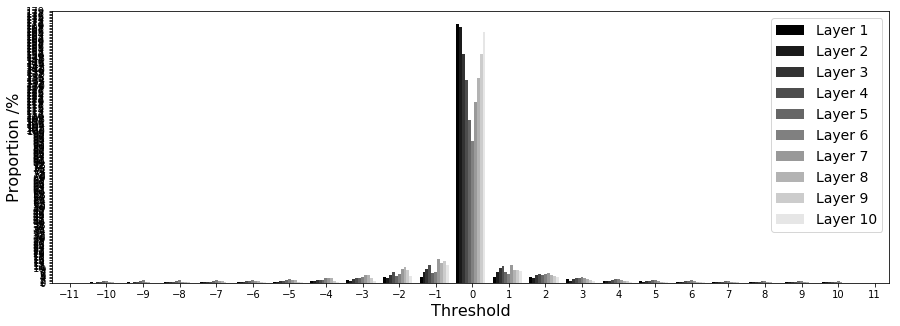

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import statistics

bar_width = 0.08
# csv2fig('tdvd.csv','tdvd_diff_distribution.svg')
CSV_PATH = '../source/3dunet/tdvd.csv'
FIG_PATH = '../generate/3dunet/tdvd_diff_distribution.svg'
data = pd.read_csv(CSV_PATH)
proportion = data.iloc[-1,2:] 
print(len(proportion))
tdvd_range = 10
range_idx = (2*tdvd_range+1)
plt.figure(figsize=(15,5))
for i in range(range_idx):
    for idx_encoder in range(5):
        proportion[i + range_idx*idx_encoder] = (proportion[i+range_idx*4*idx_encoder] + proportion[i+range_idx+range_idx*4*idx_encoder] +\
                                                 proportion[i+range_idx*2 + range_idx*4*idx_encoder] + proportion[i+range_idx*3+range_idx*4*idx_encoder])/4
#         proportion[tdvd_range + range_idx*idx_encoder] = 0 # set xaxis=0 to 0
    for idx_decoder in range(5):
        proportion[i + range_idx*idx_decoder + range_idx*5] = (proportion[i+range_idx*2*idx_decoder + range_idx*4*5] + proportion[i+range_idx+range_idx*2*idx_decoder  + range_idx*4*5])/2
#         proportion[tdvd_range + range_idx*idx_decoder + range_idx*5] = 0 # setxaxis=0 to 0

for i in range(10):
    plt.bar(bar_width*1*(i - 5) + np.linspace(-tdvd_range, tdvd_range, tdvd_range*2+1) ,2*np.array(proportion[range_idx*i: range_idx*(i+1)]),label="Layer "+str(i+1) , width=bar_width, color=(0.1*i,0.1*i,0.1*i) )
print(np.linspace(-tdvd_range, tdvd_range, tdvd_range*2+1))
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Proportion /%', fontsize=16)
plt.legend(fontsize=14)   #显示标签
plt.savefig(FIG_PATH, format='svg')
#plt.show()


In [193]:
from matplotlib import pyplot as plt
from matplotlib import colors

# fig, ax = plt.subplots(figsize=(6, 6))

cdict = {'red':   ((0.0,  0.0, 0.0),
                   (0.5,  0.5, 0.5),
                   (1.0,  1, 1.0)),

         'green': ((0.0,  0, 0.0),
                   (0.5,  1, 1),
                   (1.0,  0, 0.0)),

         'blue':  ((0.0,  1, 1),
                   (0.5,  0.5, 0.5),
                   (1.0,  0, 0))}

cmap = colors.LinearSegmentedColormap('custom', cdict)

# for i in np.linspace(0, 1):
#     # Plot 50 lines, from y = 0 to y = 1, taking a corresponding value from the cmap
#     ax.plot([-1, 1], [i, i], c=cmap(i))

layer: 0, threshold: 0, density: 14.8
layer: 0, threshold: 1, density: 11.3
layer: 0, threshold: 2, density: 7.4
layer: 0, threshold: 3, density: 5.3
layer: 0, threshold: 4, density: 4.0
layer: 0, threshold: 5, density: 3.1
layer: 0, threshold: 6, density: 2.5
layer: 0, threshold: 7, density: 2.0
layer: 0, threshold: 8, density: 1.6
layer: 0, threshold: 9, density: 1.4
layer: 1, threshold: 0, density: 15.8
layer: 1, threshold: 1, density: 8.8
layer: 1, threshold: 2, density: 5.6
layer: 1, threshold: 3, density: 4.1
layer: 1, threshold: 4, density: 3.2
layer: 1, threshold: 5, density: 2.6
layer: 1, threshold: 6, density: 2.1
layer: 1, threshold: 7, density: 1.7
layer: 1, threshold: 8, density: 1.4
layer: 1, threshold: 9, density: 1.2
layer: 2, threshold: 0, density: 24.8
layer: 2, threshold: 1, density: 15.3
layer: 2, threshold: 2, density: 10.5
layer: 2, threshold: 3, density: 8.0
layer: 2, threshold: 4, density: 6.4
layer: 2, threshold: 5, density: 5.4
layer: 2, threshold: 6, density:

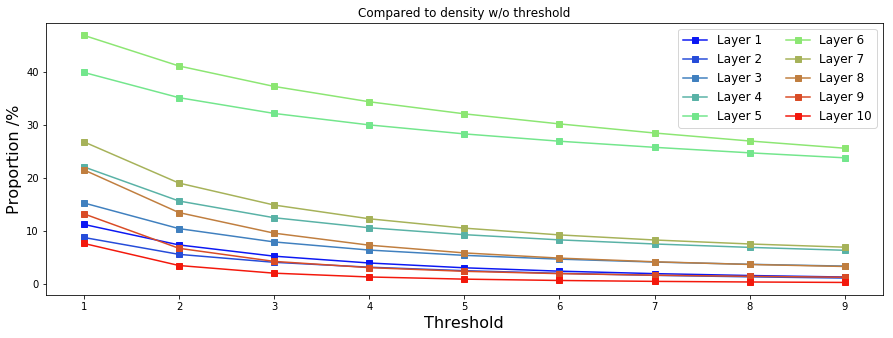

In [195]:
bar_width = 0.05
plt.figure(figsize=(15,5))
plt.title("Compared to density w/o threshold")
proportion_th = np.zeros(shape=(10,range_idx ))
for layer in range(10):
    proportion_th[layer][0] = 100 -  proportion[tdvd_range + range_idx*layer]
    x = []
    y = []
    for th in range(1,tdvd_range):
        proportion_th[layer][th] = (proportion_th[layer][th-1] - proportion[tdvd_range -th + range_idx*layer] -\
                        proportion[tdvd_range +th + range_idx*layer] ) 
        x.append(th)
        # compared
        # y.append(proportion_th[layer][th]/ proportion_th[layer][0]*100)
        # real
        y.append(proportion_th[layer][th])
    for th in range(0, tdvd_range):
        print("layer: {}, threshold: {}, density: {:.1f}".format(layer, th, proportion_th[layer][th]))
#     plt.bar(bar_width*2*(layer - 5) + np.array(x), np.array(y),label="Layer "+str(layer+1) , width=bar_width, color=(0.1*layer,0.1*layer,0.1*layer) )
    plt.plot(np.array(x), np.array(y),label="Layer "+str(layer+1), color=cmap(0.1*layer+0.05), linestyle='-',marker='s' )
# plt.gca().set_xlim(0.5,11)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Proportion /%', fontsize=16)
plt.legend(fontsize=12,ncol=2)   #显示标签
plt.savefig(FIG_PATH, format='svg')       

In [196]:
# compute whole sparsity after given threshold combinations and numbers of IA in each layer
ifm_size = [140, 39, 10.4, 3.2, 0.6, 0.35, 2.8, 11.2, 45, 135]
# density_th_layer0 = [20, 18, 17, 16, 15, 14 ,13, 12, 11, 10]
# for x in range(10, 20):
#     proportion_th[0][x] = density_th_layer0[x -10]
def whole_density(ifm_size, proportion_th, threshold, n_layer):
    density = 0
    for i in range(n_layer):
        density += proportion_th[i][threshold[i]]*ifm_size[i] / sum(ifm_size)

    return density

threshold_comb =[   
                [0, 0, 0, 0, 0,   0, 0, 0, 0, 0],
                [1, 1, 1, 1, 1,   1, 1, 1, 1, 0],
                [3, 4, 5, 5, 5,   5, 5, 5, 5, 5]
                ]

for threshold in threshold_comb:
    print("whole density is: {}".format(whole_density(ifm_size, proportion_th, threshold, 10)))

whole density is: 18.21169940189008
whole density is: 14.124194470481232
whole density is: 3.3984906912720945


168


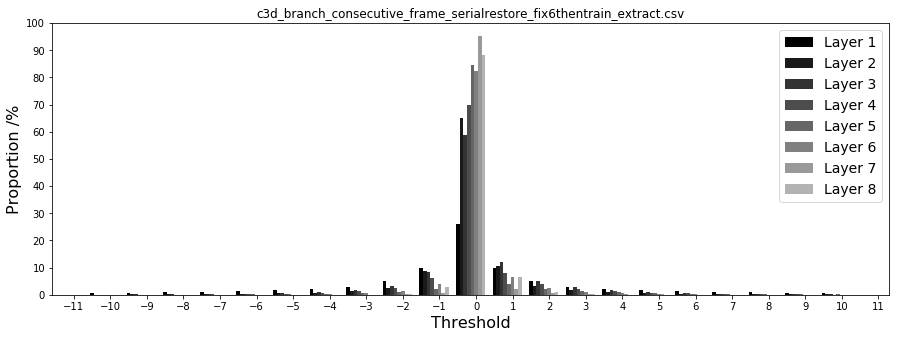

In [162]:
####################################################################################################################
# C3D
#################################################################################################################### 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import statistics
import datetime   
date_str = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

bar_width = 0.1
# csv2fig('tdvd.csv','tdvd_diff_distribution.svg')
csv_name = 'c3d_branch_consecutive_frame_serialrestore_fix6thentrain_extract.csv'
fig_name = 'tdvd_diff_distribution.svg'
data = pd.read_csv(os.path.join('../source/c3d',csv_name ))
proportion = data.iloc[-1,2:] 
print(len(proportion))
tdvd_range = 10
range_idx = (2*tdvd_range+1)
plt.figure(figsize=(15,5))
plt.title(csv_name )
# for i in range(range_idx):
#     for idx_encoder in range(8):
#         proportion[i + range_idx*idx_encoder] = (proportion[i+range_idx*4*idx_encoder] + proportion[i+range_idx+range_idx*4*idx_encoder] +\
#                                                  proportion[i+range_idx*2 + range_idx*4*idx_encoder] + proportion[i+range_idx*3+range_idx*4*idx_encoder])/4
#         proportion[tdvd_range + range_idx*idx_encoder] = 0 # set xaxis=0 to 0
#     for idx_decoder in range(5):
#         proportion[i + range_idx*idx_decoder + range_idx*5] = (proportion[i+range_idx*2*idx_decoder + range_idx*4*5] + proportion[i+range_idx+range_idx*2*idx_decoder  + range_idx*4*5])/2
# #         proportion[tdvd_range + range_idx*idx_decoder + range_idx*5] = 0 # setxaxis=0 to 0

for i in range(8):
    plt.bar(bar_width*1*(i - 5) + np.linspace(-tdvd_range, tdvd_range, tdvd_range*2+1) ,np.array(proportion[range_idx*i: range_idx*(i+1)]),label="Layer "+str(i+1) , width=bar_width, color=(0.1*i,0.1*i,0.1*i) )
# print(np.linspace(-tdvd_range, tdvd_range, tdvd_range*2+1))
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Proportion /%', fontsize=16)
plt.legend(fontsize=14)   #显示标签
plt.savefig(os.path.join('../generate/c3d', date_str+'_'+csv_name +'_' +fig_name), format='svg')

In [163]:
from matplotlib import pyplot as plt
from matplotlib import colors

# fig, ax = plt.subplots(figsize=(6, 6))

cdict = {'red':   ((0.0,  0.0, 0.0),
                   (0.5,  0.5, 0.5),
                   (1.0,  1, 1.0)),

         'green': ((0.0,  0, 0.0),
                   (0.5,  1, 1),
                   (1.0,  0, 0.0)),

         'blue':  ((0.0,  1, 1),
                   (0.5,  0.5, 0.5),
                   (1.0,  0, 0))}

cmap = colors.LinearSegmentedColormap('custom', cdict)

# for i in np.linspace(0, 1):
#     # Plot 50 lines, from y = 0 to y = 1, taking a corresponding value from the cmap
#     ax.plot([-1, 1], [i, i], c=cmap(i))

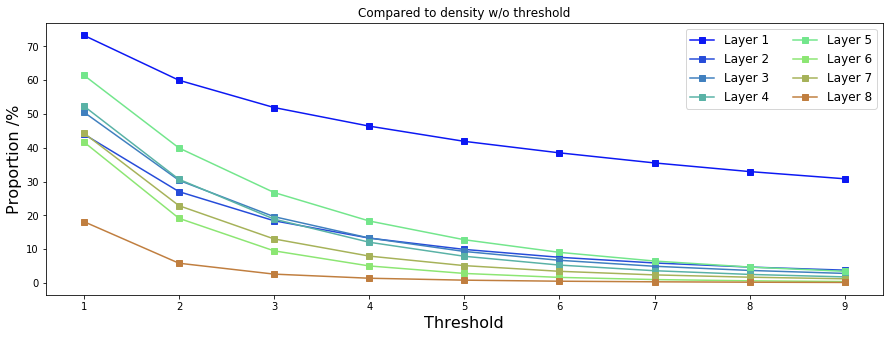

In [166]:
bar_width = 0.05
plt.figure(figsize=(15,5))
plt.title("Compared to density w/o threshold")
proportion_th = np.zeros(shape=(10,range_idx ))
for layer in range(8):
    proportion_th[layer][0] = 100 -  proportion[tdvd_range + range_idx*layer]
    x = []
    y = []
    for th in range(1,tdvd_range):
        proportion_th[layer][th] = (proportion_th[layer][th-1] - proportion[tdvd_range -th + range_idx*layer] -\
                        proportion[tdvd_range +th + range_idx*layer] ) 
        x.append(th)
        y.append(proportion_th[layer][th]/ proportion_th[layer][0]*100)
        
#     plt.bar(bar_width*2*(layer - 5) + np.array(x), np.array(y),label="Layer "+str(layer+1) , width=bar_width, color=(0.1*layer,0.1*layer,0.1*layer) )
    plt.plot(np.array(x), np.array(y),label="Layer "+str(layer+1), color=cmap(0.1*layer+0.05), linestyle='-',marker='s' )
# plt.gca().set_xlim(0.5,11)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Proportion /%', fontsize=16)
plt.legend(fontsize=12,ncol=2)   #显示标签
plt.savefig(os.path.join('../generate/c3d', date_str+'_'+csv_name +'_' +'Threshold_compared_proportion.svg'), format='svg')  

layer: 0, threshold: 0, density: 73.9
layer: 0, threshold: 1, density: 54.1
layer: 0, threshold: 2, density: 44.3
layer: 0, threshold: 3, density: 38.3
layer: 0, threshold: 4, density: 34.3
layer: 0, threshold: 5, density: 30.9
layer: 0, threshold: 6, density: 28.4
layer: 0, threshold: 7, density: 26.2
layer: 0, threshold: 8, density: 24.3
layer: 0, threshold: 9, density: 22.8
layer: 1, threshold: 0, density: 34.8
layer: 1, threshold: 1, density: 15.3
layer: 1, threshold: 2, density: 9.4
layer: 1, threshold: 3, density: 6.4
layer: 1, threshold: 4, density: 4.6
layer: 1, threshold: 5, density: 3.5
layer: 1, threshold: 6, density: 2.6
layer: 1, threshold: 7, density: 2.1
layer: 1, threshold: 8, density: 1.6
layer: 1, threshold: 9, density: 1.3
layer: 2, threshold: 0, density: 41.1
layer: 2, threshold: 1, density: 20.8
layer: 2, threshold: 2, density: 12.5
layer: 2, threshold: 3, density: 8.1
layer: 2, threshold: 4, density: 5.5
layer: 2, threshold: 5, density: 3.8
layer: 2, threshold: 6,

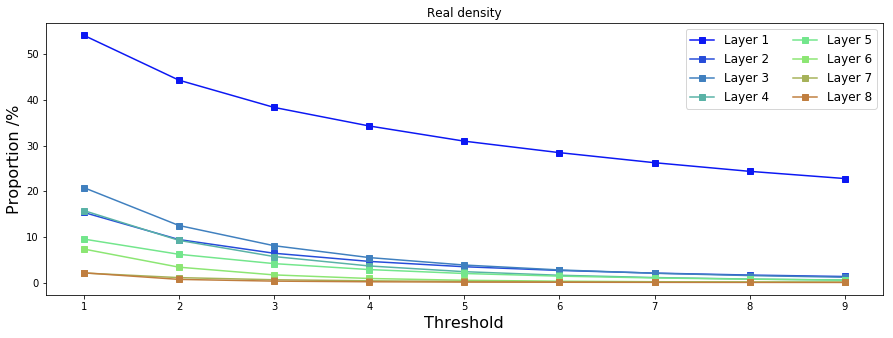

In [167]:
bar_width = 0.05
plt.figure(figsize=(15,5))
plt.title("Real density")
proportion_th = np.zeros(shape=(10,range_idx ))
for layer in range(8):
    proportion_th[layer][0] = 100 -  proportion[tdvd_range + range_idx*layer]
    x = []
    y = []
    for th in range(1,tdvd_range):
        proportion_th[layer][th] = (proportion_th[layer][th-1] - proportion[tdvd_range -th + range_idx*layer] -\
                        proportion[tdvd_range +th + range_idx*layer] ) 
        x.append(th)
        y.append(proportion_th[layer][th])
    for th in range(0, tdvd_range):
        print("layer: {}, threshold: {}, density: {:.1f}".format(layer, th, proportion_th[layer][th]))
#     plt.bar(bar_width*2*(layer - 5) + np.array(x), np.array(y),label="Layer "+str(layer+1) , width=bar_width, color=(0.1*layer,0.1*layer,0.1*layer) )
    
    plt.plot(np.array(x), np.array(y),label="Layer "+str(layer+1), color=cmap(0.1*layer+0.05), linestyle='-',marker='s' )
# plt.gca().set_xlim(0.5,11)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Proportion /%', fontsize=16)
plt.legend(fontsize=12,ncol=2)   #显示标签
plt.savefig(os.path.join('../generate/c3d', date_str+'_'+csv_name +'_' +'Threshold_abs_proportion.svg'), format='svg')  

In [172]:
# compute whole sparsity after given threshold combinations and numbers of IA in each layer
ifm_size = [0.6, 3, 0.75, 1.5, 0.2, 0.4, 0.05, 0.05]
density_th_layer0 = [20, 18, 17, 16, 15, 14 ,13, 12, 11, 10]
for x in range(10, 20):
    proportion_th[0][x] = density_th_layer0[x -10]
def whole_density(ifm_size, proportion_th, threshold, n_layer):
    density = 0
    for i in range(n_layer):
        density += proportion_th[i][threshold[i]]*ifm_size[i] / sum(ifm_size)

    return density

threshold_comb =[   
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [3, 3, 3, 3, 3, 3, 3, 3],
                    [7, 2, 3, 2, 3, 3, 4, 4],
                    [10,7, 5, 5, 5, 5, 5, 2],
                    [17,9,5, 5, 6, 6, 6, 5]
                ]

for threshold in threshold_comb:
    print("whole density is: {}".format(whole_density(ifm_size, proportion_th, threshold, 8)))

whole density is: 35.98480255114504
whole density is: 8.908366567175571
whole density is: 9.98160710534351
whole density is: 3.8561201106870233
whole density is: 2.7490990946564886
